In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from itertools import combinations

plt.rcParams['svg.fonttype'] = 'none'

In [2]:
df = pd.read_csv('cells_concat_filtered.csv')

In [3]:
def plot_violin_by_construct(df, constructs, column='Ef_cell', colors=None, figsize=(12, 6), top = .5, bot = 0.1,
                              title=None, ylabel=None, show_pvalues=True, xlabels=None, labels=True, n=30, hline=True):
    """
    Plot violin plots for specified constructs, with each violin showing the distribution
    of data points from individual wells, overlaid for each construct.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the data
    constructs : list
        List of construct identifiers to plot (in desired order)
    column : str, default='Ef_cell'
        Column name to plot on y-axis
    colors : list or None, default=None
        List of colors for each construct. If None, uses default matplotlib colors
    figsize : tuple, default=(12, 6)
        Figure size (width, height)
    top : float, default=0.5
        Top limit of y-axis
    bot : float, default=0.1
        Bottom limit of y-axis
    title : str or None
        Plot title. If None, auto-generates title
    ylabel : str or None
        Y-axis label. If None, uses column name
    show_pvalues : bool, default=True
        Whether to show significance bars between constructs
    xlabels : list or None, default=None
        Labels for x-axis tick marks (in order of constructs). If None, x-ticks are removed
    labels : bool, default=True
        Whether to show y-axis labels (tick marks and ylabel)
    n : int, default=30
        Minimum number of data points required per well to include it in the plot
    hline : bool, default=True
        Whether to show grey dashed horizontal line at mean of medians
    
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    """
    
    # Filter dataframe for specified constructs
    plot_df = df[df['construct'].isin(constructs)].copy()
    
    # Ensure constructs are in the specified order
    plot_df['construct'] = pd.Categorical(plot_df['construct'], 
                                          categories=constructs, 
                                          ordered=True)
    plot_df = plot_df.sort_values('construct')
    
    # Remove NaN values from the column of interest
    plot_df = plot_df[plot_df[column].notna()]
    
    # Set default colors if not provided
    if colors is None:
        colors = ['black'] * len(constructs)
    
    # Create figure with explicit subplot positioning
    fig = plt.figure(figsize=figsize)
    
    # ALWAYS use the same plot area dimensions
    ax = fig.add_axes([0.15, 0.1, 0.8, 0.85])  # left, bottom, width, height
    
    # Plot violins for each construct
    positions = np.arange(len(constructs))
    
    # Store well medians for each construct for significance testing
    construct_well_medians = {}
    
    for i, (construct, color) in enumerate(zip(constructs, colors)):
        construct_data = plot_df[plot_df['construct'] == construct]
        
        # Get unique wells for this construct
        wells = construct_data['well'].unique()
        
        # Store well medians for mean and std calculation
        well_medians = []
        
        # Plot each well as a separate violin, overlaid
        for well in wells:
            well_data = construct_data[construct_data['well'] == well][column].values
            
            if len(well_data) >= n:  # Filter by minimum n
                well_medians.append(np.median(well_data))
                
                parts = ax.violinplot([well_data], positions=[i], 
                                     widths=0.6, showmeans=False, 
                                     showmedians=False, showextrema=False)
                
                for pc in parts['bodies']:
                    pc.set_alpha(0.3)
                    pc.set_facecolor('none')
                    pc.set_edgecolor(color)
        
        # Store well medians for this construct
        construct_well_medians[construct] = well_medians
        
        # Calculate mean of medians and std of medians
        if len(well_medians) > 0:
            mean_of_medians = np.mean(well_medians)
            std_of_medians = np.std(well_medians, ddof=1) if len(well_medians) > 1 else 0
            
            # Add grey dashed horizontal line at mean of medians (only if hline=True)
            if hline:
                ax.axhline(y=mean_of_medians,
                          color='grey', linestyle='--', linewidth=1, zorder=5, alpha = .7)
            
            # Plot mean of medians as a point with error bar
            ax.errorbar(i, mean_of_medians, yerr=std_of_medians, 
                       fmt='o', color='black', markersize=8, 
                       linewidth=2, capsize=5, capthick=2, zorder=10)
    
    # Set y-axis limits before positioning text and bars
    ax.set_ylim(bottom=bot, top=top)
    
    # Set y-axis ticks at multiples of 0.1
    y_ticks = np.arange(np.ceil(bot * 10) / 10, top + 0.01, 0.1)
    ax.set_yticks(y_ticks)
    
    # Get y limits for positioning text
    y_min, y_max = ax.get_ylim()
    y_range = y_max - y_min
    
    # Add construct labels inside the plot, just above baseline
    # Position: 2% of y-range above the bottom
    for i, construct in enumerate(constructs):
        ax.text(i, y_min + y_range * 0.00, 
               f'#{construct}', ha='center', va='bottom', 
               fontsize=12, fontweight='bold')
    
    # Perform t-tests between all pairs of constructs
    if show_pvalues and len(constructs) > 1:
        pairwise_pvalues = []
        
        for c1, c2 in combinations(constructs, 2):
            well_medians1 = construct_well_medians[c1]
            well_medians2 = construct_well_medians[c2]
            
            if len(well_medians1) > 1 and len(well_medians2) > 1:
                t_stat, p_val = stats.ttest_ind(well_medians1, well_medians2)
                pairwise_pvalues.append((constructs.index(c1), constructs.index(c2), p_val))
        
        # SIGNIFICANCE BAR POSITION: STARTS 12% OF Y-RANGE ABOVE THE BOTTOM, STACKING UPWARD
        bar_height = y_min + y_range * 0.06
        
        for idx, (i, j, p_val) in enumerate(pairwise_pvalues):
            # Determine significance level
            if p_val < 0.0001:
                sig_text = '****'
            elif p_val < 0.001:
                sig_text = '***'
            elif p_val < 0.01:
                sig_text = '**'
            elif p_val < 0.05:
                sig_text = '*'
            else:
                sig_text = 'ns'
            
            # Calculate bar position (each bar is 5% of y-range higher than previous)
            current_height = bar_height + (y_range * 0.05 * idx)
            
            # Draw bar in I-I shape (vertical, horizontal, vertical)
            ax.plot([i, i], 
                   [current_height + y_range * 0.02, current_height + y_range * 0.04],
                   linewidth=1, color='black')
            ax.plot([i, j], 
                   [current_height + y_range * 0.02, current_height + y_range * 0.02],
                   linewidth=1, color='black')
            ax.plot([j, j], 
                   [current_height + y_range * 0.02, current_height + y_range * 0.04],
                   linewidth=1, color='black')
            
            # Add text above the bar
            ax.text((i + j) / 2, current_height + y_range * 0.015, 
                   sig_text, 
                   ha='center', va='bottom', fontsize=12)
    
    # Formatting
    if xlabels is not None:
        ax.set_xticks(positions)
        ax.set_xticklabels(xlabels)
    else:
        ax.set_xticks([])
    
    # Set x-axis limits to add consistent padding around first and last violins
    ax.set_xlim(-0.5, len(constructs) - 0.5)
    
    # Handle y-axis labels based on labels parameter
    if labels:
        # Set y-axis label aligned with tick labels
        ax.set_ylabel(ylabel if ylabel else column, fontsize=14)
        # Position label to align with tick labels (not outside them)
        ax.yaxis.set_label_coords(-0.02, 0.5)
    else:
        # Remove y-axis tick labels and label, but keep tick marks visible
        ax.set_yticklabels([])
        ax.set_ylabel('')
    
    #ax.set_title(title if title else f'{column} Distribution by Construct', fontsize=12)
    
    return fig, ax

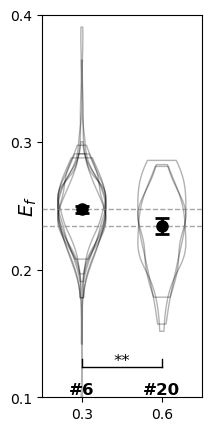

In [4]:
fig, ax = plot_violin_by_construct(df, constructs=[6, 20], 
                                     column='Ef_cell',
                                     xlabels=['0.3', '0.6'],
                                     figsize=(2, 4.5), top = .4, bot = 0.1,
                                     ylabel=r'$E_{f}$', n = 25)
plt.savefig('Figure_graphs/Fig2/6-20.svg')

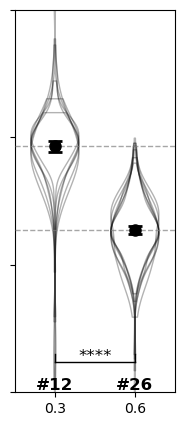

In [5]:
fig, ax = plot_violin_by_construct(df, constructs=[12, 26], 
                                     column='Ef_cell',
                                     xlabels=['0.3', '0.6'],
                                     figsize=(2, 4.5), top = .4, bot = 0.1,
                                     ylabel = r'$E_{f}$',
                                     labels = False)
plt.savefig('Figure_graphs/Fig2/12-26.svg')

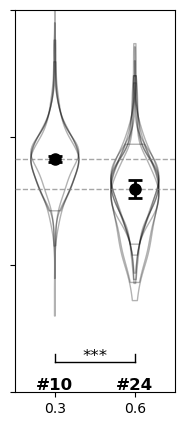

In [6]:
fig, ax = plot_violin_by_construct(df, constructs=[10, 24], 
                                     column='Ef_cell',
                                     xlabels=['0.3', '0.6'],
                                     figsize=(2, 4.5), top = .4, bot = 0.1,
                                     ylabel = r'$E_{f}$',
                                     labels = False)
plt.savefig('Figure_graphs/Fig2/10-24.svg')

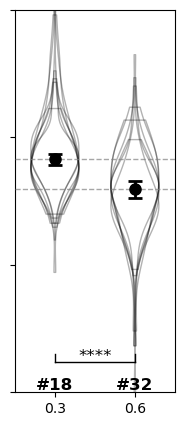

In [7]:
fig, ax = plot_violin_by_construct(df, constructs=[18, 32], 
                                     column='Ef_cell',
                                     xlabels=['0.3', '0.6'],
                                     figsize=(2, 4.5), top = .4, bot = 0.1,
                                     ylabel = r'$E_{f}$',
                                     labels = False)
plt.savefig('Figure_graphs/Fig2/18-32.svg')

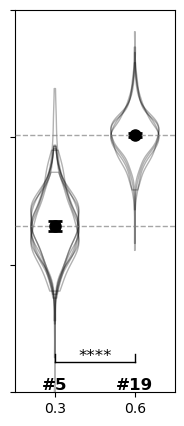

In [8]:
fig, ax = plot_violin_by_construct(df, constructs=[5, 19], 
                                     column='Ef_cell',
                                     xlabels=['0.3', '0.6'],
                                     figsize=(2, 4.5), top = .4, bot = 0.1,
                                     ylabel = r'$E_{f}$',
                                     labels = False)
plt.savefig('Figure_graphs/Fig2/5-19.svg')

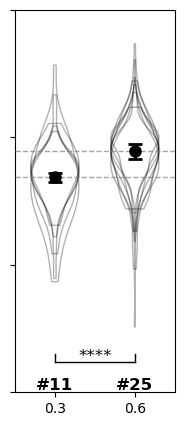

In [9]:
fig, ax = plot_violin_by_construct(df, constructs=[11, 25], 
                                     column='Ef_cell',
                                     xlabels=['0.3', '0.6'],
                                     figsize=(2, 4.5), top = .4, bot = 0.1,
                                     ylabel = r'$E_{f}$',
                                     labels = False)
plt.savefig('Figure_graphs/Fig2/11-25.svg')

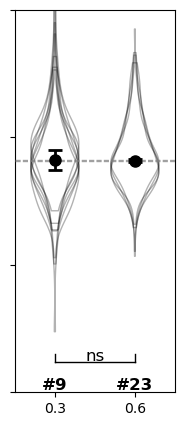

In [10]:
fig, ax = plot_violin_by_construct(df, constructs=[9, 23], 
                                     column='Ef_cell',
                                     xlabels=['0.3', '0.6'],
                                     figsize=(2, 4.5), top = .4, bot = 0.1,
                                     ylabel = r'$E_{f}$',
                                     labels = False)
plt.savefig('Figure_graphs/Fig2/9-23.svg')

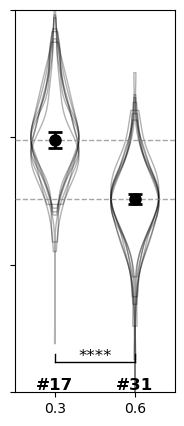

In [11]:
fig, ax = plot_violin_by_construct(df, constructs=[17, 31], 
                                     column='Ef_cell',
                                     xlabels=['0.3', '0.6'],
                                     figsize=(2, 4.5), top = .4, bot = 0.1,
                                     ylabel = r'$E_{f}$',
                                     labels = False)
plt.savefig('Figure_graphs/Fig2/17-31.svg')

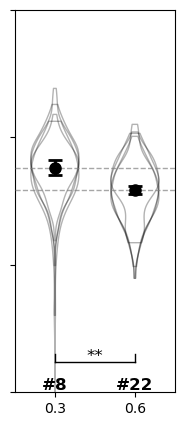

In [12]:
fig, ax = plot_violin_by_construct(df, constructs=[8, 22], 
                                     column='Ef_cell',
                                     xlabels=['0.3', '0.6'],
                                     figsize=(2, 4.5), top = .4, bot = 0.1,
                                     ylabel = r'$E_{f}$',
                                     labels = False)
plt.savefig('Figure_graphs/Fig2/8-22.svg')

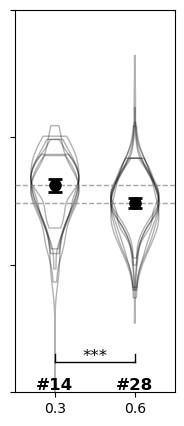

In [13]:
fig, ax = plot_violin_by_construct(df, constructs=[14, 28], 
                                     column='Ef_cell',
                                     xlabels=['0.3', '0.6'],
                                     figsize=(2, 4.5), top = .4, bot = 0.1,
                                     ylabel = r'$E_{f}$',
                                     labels = False)
plt.savefig('Figure_graphs/Fig2/14-28.svg')

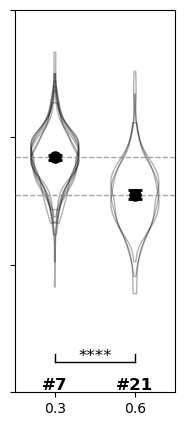

In [14]:
fig, ax = plot_violin_by_construct(df, constructs=[7, 21], 
                                     column='Ef_cell',
                                     xlabels=['0.3', '0.6'],
                                     figsize=(2, 4.5), top = .4, bot = 0.1,
                                     ylabel = r'$E_{f}$',
                                     labels = False)
plt.savefig('Figure_graphs/Fig2/7-21.svg')

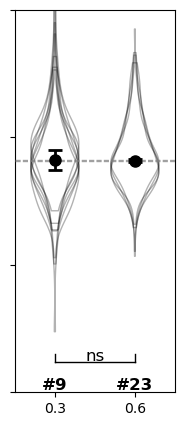

In [15]:
fig, ax = plot_violin_by_construct(df, constructs=[9, 23], 
                                     column='Ef_cell',
                                     xlabels=['0.3', '0.6'],
                                     figsize=(2, 4.5), top = .4, bot = 0.1,
                                     ylabel = r'$E_{f}$',
                                     labels = False)
plt.savefig('Figure_graphs/Fig2/9-23.svg')

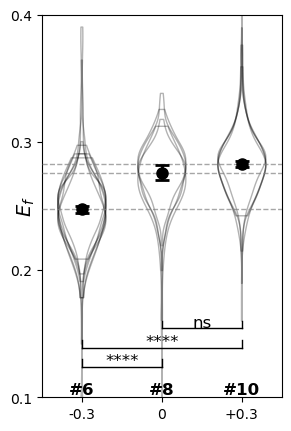

In [16]:
fig, ax = plot_violin_by_construct(df, constructs=[6, 8, 10], 
                                     column='Ef_cell',
                                     xlabels=['-0.3', '0', '+0.3'],
                                     figsize=(3, 4.5), top = .4, bot = 0.1,
                                     ylabel = r'$E_{f}$',
                                     labels = True)
plt.savefig('Figure_graphs/Fig2/6-8-10.svg')

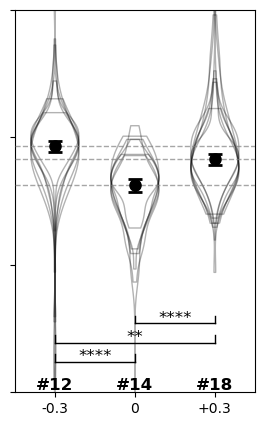

In [17]:
fig, ax = plot_violin_by_construct(df, constructs=[12, 14, 18], 
                                     column='Ef_cell',
                                     xlabels=['-0.3', '0', '+0.3'],
                                     figsize=(3, 4.5), top = .4, bot = 0.1,
                                     ylabel =r'$E_{f}$',
                                     labels = False)
plt.savefig('Figure_graphs/Fig2/12-14-18.svg')

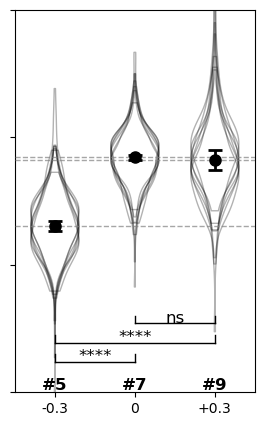

In [18]:
fig, ax = plot_violin_by_construct(df, constructs=[5, 7, 9], 
                                     column='Ef_cell',
                                     xlabels=['-0.3', '0', '+0.3'],
                                     figsize=(3, 4.5), top = .4, bot = 0.1,
                                     ylabel = r'$E_{f}$',
                                     labels = False)
plt.savefig('Figure_graphs/Fig2/5-7-9.svg')

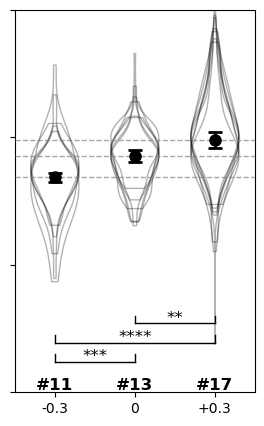

In [19]:
fig, ax = plot_violin_by_construct(df, constructs=[11, 13, 17], 
                                     column='Ef_cell',
                                     xlabels=['-0.3', '0', '+0.3'],
                                     figsize=(3, 4.5), top = .4, bot = 0.1,
                                     ylabel = r'$E_{f}$',
                                     labels = False)
plt.savefig('Figure_graphs/Fig2/11-13-17.svg')

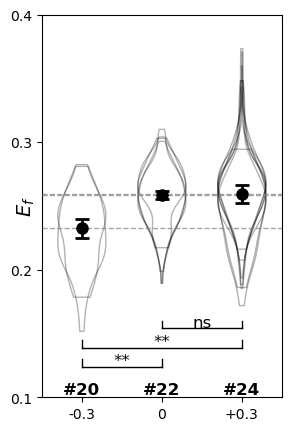

In [20]:
fig, ax = plot_violin_by_construct(df, constructs=[20, 22, 24], 
                                     column='Ef_cell',
                                     xlabels=['-0.3', '0', '+0.3'],
                                     figsize=(3, 4.5), top = .4, bot = 0.1,
                                     ylabel = r'$E_{f}$',
                                     labels = True)
plt.savefig('Figure_graphs/Fig2/20-22-24.svg')

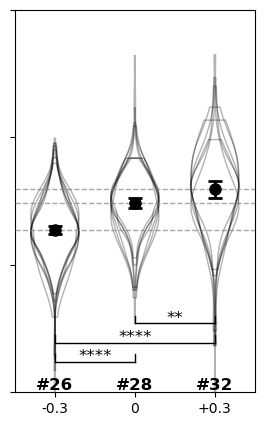

In [21]:
fig, ax = plot_violin_by_construct(df, constructs=[26, 28, 32], 
                                     column='Ef_cell',
                                     xlabels=['-0.3', '0', '+0.3'],
                                     figsize=(3, 4.5), top = .4, bot = 0.1,
                                     ylabel =r'$E_{f}$',
                                     labels = False)
plt.savefig('Figure_graphs/Fig2/26-28-32.svg')

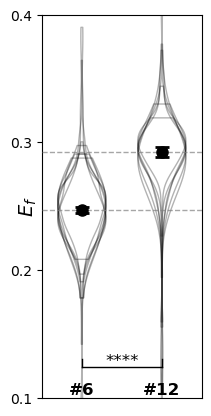

In [22]:
fig, ax = plot_violin_by_construct(df, constructs=[6, 12], 
                                     column='Ef_cell',
                                     figsize=(2, 4.5), top = .4, bot = 0.1,
                                     ylabel = r'$E_{f}$',
                                     labels = True)
plt.savefig('Figure_graphs/Fig3/6-12.svg')

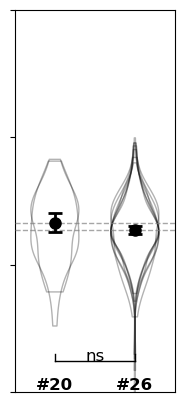

In [23]:
fig, ax = plot_violin_by_construct(df, constructs=[20, 26], 
                                     column='Ef_cell',
                                     figsize=(2, 4.5), top = .4, bot = 0.1,
                                     ylabel = r'$E_{f}$',
                                     labels = False)
plt.savefig('Figure_graphs/Fig3/20-26.svg')

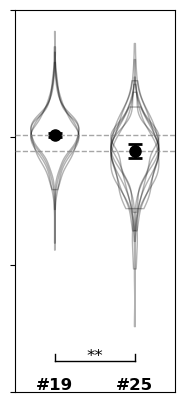

In [24]:
fig, ax = plot_violin_by_construct(df, constructs=[19, 25], 
                                     column='Ef_cell',
                                     figsize=(2, 4.5), top = .4, bot = 0.1,
                                     ylabel = r'$E_{f}$',
                                     labels = False)
plt.savefig('Figure_graphs/Fig3/19-25.svg')

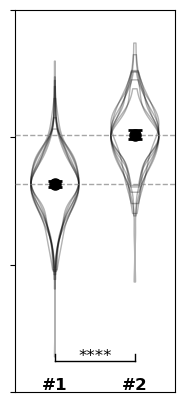

In [25]:
fig, ax = plot_violin_by_construct(df, constructs=[1, 2], 
                                     column='Ef_cell',
                                     figsize=(2, 4.5), top = .4, bot = 0.1,
                                     ylabel = r'$E_{f}$',
                                     labels = False)
plt.savefig('Figure_graphs/Fig3/1-2.svg')

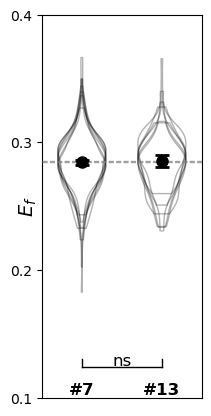

In [26]:
fig, ax = plot_violin_by_construct(df, constructs=[7, 13], 
                                     column='Ef_cell',
                                     figsize=(2, 4.5), top = .4, bot = 0.1,
                                     ylabel = r'$E_{f}$',
                                     labels = True)
plt.savefig('Figure_graphs/Fig3/7-13.svg')

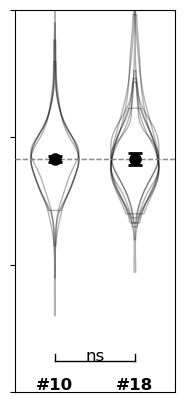

In [27]:
fig, ax = plot_violin_by_construct(df, constructs=[10, 18], 
                                     column='Ef_cell',
                                     figsize=(2, 4.5), top = .4, bot = 0.1,
                                     ylabel = r'$E_{f}$',
                                     labels = False)
plt.savefig('Figure_graphs/Fig3/10-18.svg')

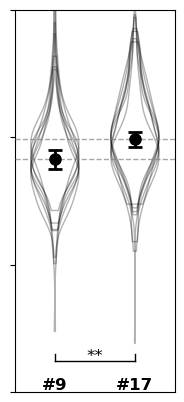

In [28]:
fig, ax = plot_violin_by_construct(df, constructs=[9, 17], 
                                     column='Ef_cell',
                                     figsize=(2, 4.5), top = .4, bot = 0.1,
                                     ylabel = r'$E_{f}$',
                                     labels = False)
plt.savefig('Figure_graphs/Fig3/9-17.svg')

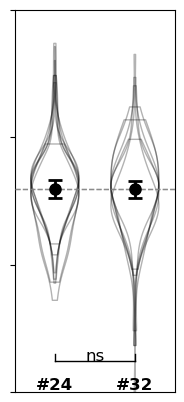

In [29]:
fig, ax = plot_violin_by_construct(df, constructs=[24, 32], 
                                     column='Ef_cell',
                                     figsize=(2, 4.5), top = .4, bot = 0.1,
                                     ylabel = r'$E_{f}$',
                                     labels = False)
plt.savefig('Figure_graphs/Fig3/24-32.svg')

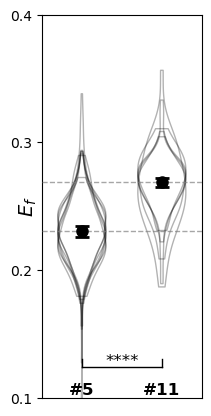

In [30]:
fig, ax = plot_violin_by_construct(df, constructs=[5, 11], 
                                     column='Ef_cell',
                                     figsize=(2, 4.5), top = .4, bot = 0.1,
                                     ylabel = r'$E_{f}$',
                                     labels = True)
plt.savefig('Figure_graphs/Fig3/5-11.svg')

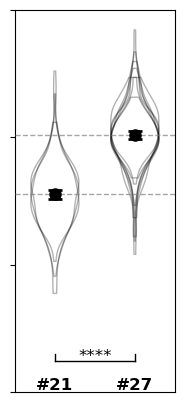

In [31]:
fig, ax = plot_violin_by_construct(df, constructs=[21, 27], 
                                     column='Ef_cell',
                                     figsize=(2, 4.5), top = .4, bot = 0.1,
                                     ylabel = r'$E_{f}$',
                                     labels = False)
plt.savefig('Figure_graphs/Fig3/21-27.svg')

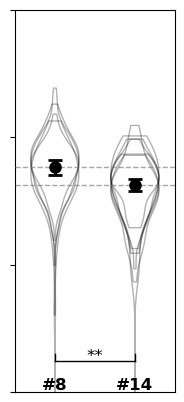

In [32]:
fig, ax = plot_violin_by_construct(df, constructs=[8, 14], 
                                     column='Ef_cell',
                                     figsize=(2, 4.5), top = .4, bot = 0.1,
                                     ylabel = r'$E_{f}$',
                                     labels = False)
plt.savefig('Figure_graphs/Fig3/8-14.svg')

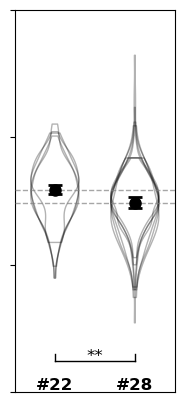

In [33]:
fig, ax = plot_violin_by_construct(df, constructs=[22, 28], 
                                     column='Ef_cell',
                                     figsize=(2, 4.5), top = .4, bot = 0.1,
                                     ylabel = r'$E_{f}$',
                                     labels = False)
plt.savefig('Figure_graphs/Fig3/22-28.svg')

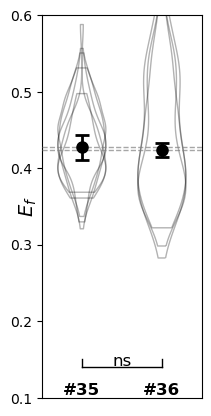

In [34]:
fig, ax = plot_violin_by_construct(df, constructs=[35, 36], 
                                     column='Ef_cell',
                                     figsize=(2, 4.5), top = .6, bot = 0.1,
                                     ylabel = r'$E_{f}$',
                                     labels = True)
plt.savefig('Figure_graphs/Fig3/35-36.svg')

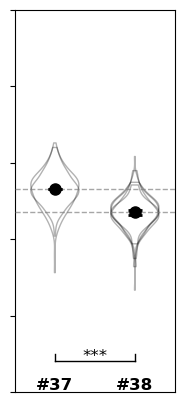

In [35]:
fig, ax = plot_violin_by_construct(df, constructs=[37, 38], 
                                     column='Ef_cell',
                                     figsize=(2, 4.5), top = .6, bot = 0.1,
                                     ylabel = r'$E_{f}$',
                                     labels = False)
plt.savefig('Figure_graphs/Fig3/37-38.svg')

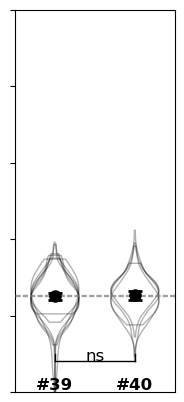

In [36]:
fig, ax = plot_violin_by_construct(df, constructs=[39, 40], 
                                     column='Ef_cell',
                                     figsize=(2, 4.5), top = .6, bot = 0.1,
                                     ylabel = r'$E_{f}$',
                                     labels = False)
plt.savefig('Figure_graphs/Fig3/39-40.svg')

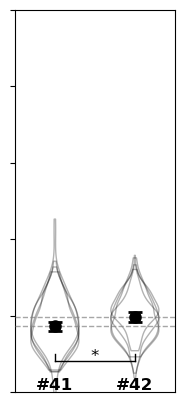

In [37]:
fig, ax = plot_violin_by_construct(df, constructs=[41, 42], 
                                     column='Ef_cell',
                                     figsize=(2, 4.5), top = .6, bot = 0.1,
                                     ylabel = r'$E_{f}$',
                                     labels = False)
plt.savefig('Figure_graphs/Fig3/41-42.svg')

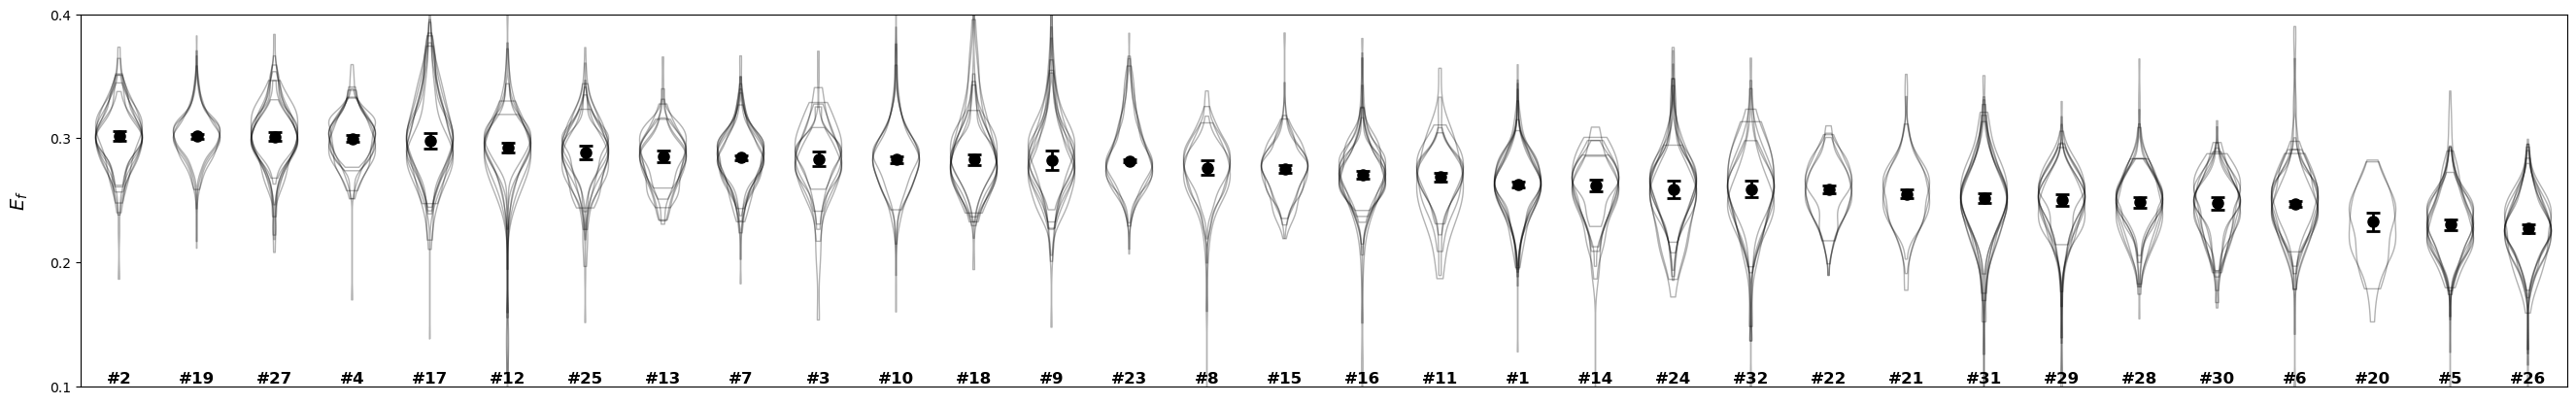

In [38]:
# Calculate mean of medians for constructs 1-32
construct_means = []

for construct in range(1, 33):
    construct_data = df[df['construct'] == construct]
    wells = construct_data['well'].unique()
    
    well_medians = []
    for well in wells:
        well_data = construct_data[construct_data['well'] == well]['Ef_cell'].dropna().values
        if len(well_data) >= 30:  # Using same filter as your function
            well_medians.append(np.median(well_data))
    
    if len(well_medians) > 0:
        mean_of_medians = np.mean(well_medians)
        construct_means.append((construct, mean_of_medians))

# Sort by mean_of_medians in descending order
construct_means.sort(key=lambda x: x[1], reverse=True)

# Extract just the construct numbers as a list
sorted_constructs = [c[0] for c in construct_means]


# Now you can use it:
fig, ax = plot_violin_by_construct(df, constructs=sorted_constructs, 
                                     column='Ef_cell',
                                     figsize=(32, 4.5), top=.4, bot=0.1,
                                     ylabel=r'$E_{f}$',
                                     labels=True,
                                     show_pvalues=False,
                                     hline = False)

plt.savefig('Figure_graphs/Fig2/sorted_1-32.svg')

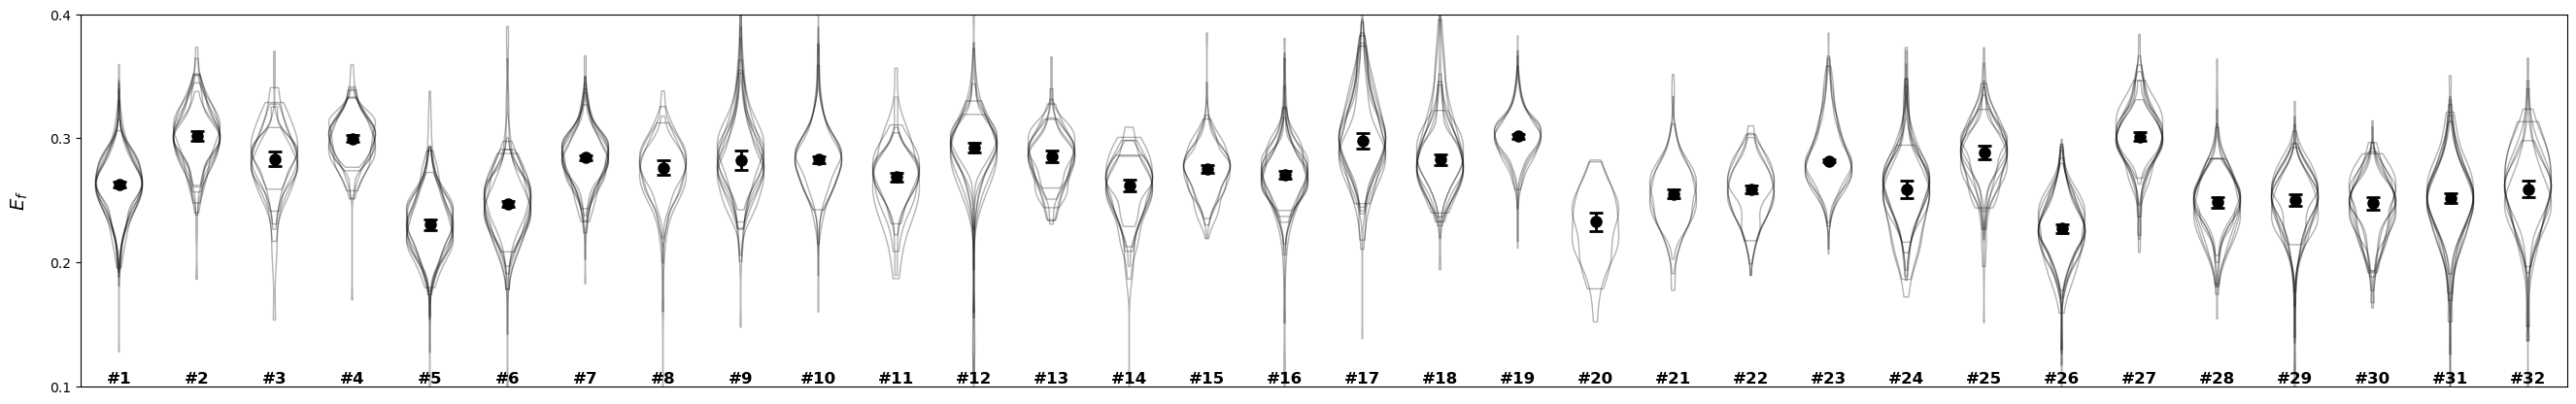

In [39]:
fig, ax = plot_violin_by_construct(df, constructs=np.arange(1, 33), 
                                     column='Ef_cell',
                                     figsize=(32, 4.5), top=.4, bot=0.1,
                                     ylabel=r'$E_{f}$',
                                     labels=True,
                                     show_pvalues=False,
                                     hline = False)

plt.savefig('Figure_graphs/Fig2/1-32.svg')